In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, HTML

from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

In [27]:
class DynSys:
    def __init__(self, param):
        self.param = param
        N_DATA, N_NODE, ALPHA = param['N_DATA'], param['N_NODE'], param['ALPHA']
        T, STD = param['T'], param['STD']
        
        #ALPHA_RAND = np.linspace(ALPHA, 1.0, N_NODE)

        ################################
        # Create Interaction matrix
        ################################
        self.M = np.zeros((N_NODE, N_NODE))
        for i in range(N_NODE):
            self.M[i, i] = ALPHA #ALPHA_RAND[i]

        for i in range(N_NODE-1):
            self.M[i + 1, i] = 1 - ALPHA #ALPHA_RAND[i]

        ################################
        # Create data
        ################################
        self.data = np.zeros((N_NODE, N_DATA))
        for i in range(1, N_DATA):
            self.data[:, i] = self.M.dot(self.data[:, i-1])        # Propagate signal
            self.data[0, i] += np.sin(2 * np.pi * i / T)           # Input to the first node
            self.data[:, i] += np.random.normal(0, STD, N_NODE)    # Noise to all nodes
           
        
    def computeTE(self, min_lag, max_lag):
        # a) Convert data to ITDxl format
        dataIDTxl = Data(self.data, dim_order='ps')

        # b) Initialise analysis object and define settings
        network_analysis = MultivariateTE()
        settings = {'cmi_estimator': 'JidtGaussianCMI',
                    'max_lag_sources': max_lag,
                    'min_lag_sources': min_lag}

        # c) Run analysis
        return network_analysis.analyse_network(settings=settings, data=dataIDTxl)

            
    def plot(self):    
        fig, ax = plt.subplots(ncols=2, figsize=(15,5))
        ax[0].imshow(self.M)
        ax[0].set_title("Connectivity-matrix")
        for j in range(self.param['N_NODE']):
            ax[1].plot(self.data[j], label=str(j))
        ax[1].legend()
        ax[1].set_title("Dynamics")
        plt.show()
    
# Convert results structure into Pandas dataframe for better usability
def parseResults(results, N_NODE):
    
    cols = ['src', 'trg', 'te', 'lag', 'p']
    df = pd.DataFrame([], columns=cols)
    
    for i in range(N_NODE):
        rezThis = results.get_single_target(i, fdr=False)
        
        # Convert numpy arrays to lists to concatenate
        # Make sure that if None returned, replace with empty list
        # none2lst = lambda l: list(l) if l is not None else []
        
        # If any connections were found, get their data  at all was found
        if rezThis['selected_sources_te'] is not None:
            te  = rezThis['selected_sources_te']
            p   = rezThis['selected_sources_pval']
            lag = [val[1] for val in rezThis['selected_vars_sources']]
            src = [val[0] for val in rezThis['selected_vars_sources']]
            trg = [i] * len(te)

            df = df.append(pd.DataFrame(list(zip(src, trg, te, lag, p)), columns=cols), ignore_index=True)
    
#     df = pd.DataFrame.from_dict(out)
    df = df.sort_values(by=['src', 'trg'])
    
    return df


# Plot various statistics of the results, such as real and fake connection TE
def analysePlotResults(paramLst, resultsLst, DS1):
    N_PARAM = len(paramLst)
    
    # Create keys for found connections
    key2idx = {}
    for rez in resultsLst:
        for index, row in rez.iterrows():
            key = (int(row['src']), int(row['trg']))
            if key not in key2idx:
                key2idx[key] = len(key2idx)

    N_CONN_FOUND = len(key2idx)
    isReal = np.array([DS1.M[j,i] != 0 for i,j in key2idx.keys()])
    statsTE = np.zeros((N_CONN_FOUND, N_PARAM)) + np.nan
    statsLag = np.zeros((N_CONN_FOUND, N_PARAM)) + np.nan

    # Fill in computed TE and lags for found connections
    for iParam, rez in enumerate(resultsLst):
        for index, row in rez.iterrows():
            key = (int(row['src']), int(row['trg']))
            idx = key2idx[key]

            # Fill in this data point
            statsTE[idx][iParam] = row['te']
            statsLag[idx][iParam] = row['lag']

    ######################
    # Analysis
    ######################

    nReal = np.zeros(N_PARAM)  # Number of real connections found
    nFake = np.zeros(N_PARAM)  # Number of fake connections found
    M_AVG = np.zeros((param['N_NODE'], param['N_NODE']))  # Frequency of each connection

    maxFakeMinReal = np.divide(
        np.nanmax(statsTE[np.logical_not(isReal)], axis=0),
        np.nanmin(statsTE[isReal], axis = 0))

    for key, idx in key2idx.items():
        connExist = np.logical_not(np.isnan(statsTE[idx]))  # When does this connection exist

        if isReal[idx]:
            nReal += connExist
        else:
            nFake += connExist

        M_AVG[key[1], key[0]] = np.sum(connExist)# / N_PARAM

    ######################
    # Plot Analysis results
    ######################

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    ax[0][0].semilogx(paramLst, nReal, label='nReal')
    ax[0][0].semilogx(paramLst, nFake, label='nFake')
    ax[0][0].legend()
    ax[0][0].set_title('Number of real and fake connections')

    im = ax[1][0].imshow(M_AVG, cmap='gray')
    ax[1][0].set_title('Frequency of each connection')
    fig.colorbar(im, ax=ax[1][0])

    for key, idx in key2idx.items():
        ax[0][1].loglog(paramLst, statsTE[idx], '.-', label=str(key))
    #ax[0][1].legend()
    ax[0][1].set_title('TE for each connection')

    ax[1][1].semilogx(paramLst, maxFakeMinReal, '.-')
    ax[1][1].set_title('Ratio of TE: max(fake) / min(real)')

    for key, idx in key2idx.items():
        if isReal[idx]:
            ax[0][2].semilogx(paramLst, statsLag[idx], '.', label=str(key))
        else:
            ax[1][2].semilogx(paramLst, statsLag[idx], '.', label=str(key))
    #ax[0][2].legend()
    #ax[1][2].legend()
    ax[0][2].set_title('Lag distribution for real connections')
    ax[1][2].set_title('Lag distribution for fake connections')
    
    # Set same x-range to all plots, in case nothing is found for some plots
    ax[0][0].set_xlim(0.9*np.min(paramLst), 1.1*np.max(paramLst))
    ax[0][1].set_xlim(0.9*np.min(paramLst), 1.1*np.max(paramLst))
    ax[1][1].set_xlim(0.9*np.min(paramLst), 1.1*np.max(paramLst))
    ax[0][2].set_xlim(0.9*np.min(paramLst), 1.1*np.max(paramLst))
    ax[1][2].set_xlim(0.9*np.min(paramLst), 1.1*np.max(paramLst))

    plt.show()
    

## 2. STATISTICAL SANITY CHECK

In [3]:
# Set default parameters
param = {
    'ALPHA'   : 0.9,
    'N_NODE'  : 12,
    'N_DATA'  : 4000,
    'T'       : 100,
    'STD'     : 0.2
}

min_lag, max_lag = 1, 5

### 2.1 Effect of max_te_lag parameter

In the DynSys in question, the correct lag is 1. But what if it finds some extra junk at higher ranks

In [4]:
%%time

maxLagLst = list(range(1, 7))

# Create dynamical system and compute TE
DS1 = DynSys(param)
resultsLst = [DS1.computeTE(1, max_lag) for max_lag in maxLagLst]

Adding data with properties: 12 processes, 4000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (4, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1), (3, 1), (1, 1), (8, 1)]
testing candidate: (2, 1)

testing candidate: (0, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (6, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 1)]
final target samples: [(7, 1)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (11, 1)]
testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (11, 1) maximum statistic, n_perm: 200
 -- not

testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (1, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 2), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 2)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (1, 1), (1, 2), (2, 1), (2, 2), (4, 1), (4, 2), (5, 1), (5

testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (10, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (9, 2), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1), (9, 2)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2), (4, 

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (5, 3), (6, 1), (6, 2), (6, 3), (7, 1), (7, 2), (7, 3), (8, 1), (8, 2), (8, 3), (9, 1), (9, 2), (9, 3), (10, 1), (10, 2), (10, 3), (11, 1), (11, 2), (11, 3)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (8, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 3), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 3)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9,

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (5, 3), (6, 1), (6, 2), (6, 3), (7, 1), (7, 2), (7, 3), (8, 1), (8, 2), (8, 3), (10, 1), (10, 2), (10, 3), (11, 1), (11, 2), (11, 3)]
testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (8, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (9, 3), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1), (9, 3)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 

testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (1, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 4), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 4)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidat

testing candidate: (8, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4), (5, 1), (5, 2), (5, 3), (5, 4), (6, 1), (6, 2), (6, 3), (6, 4), (7, 1), (7, 2), (7, 3), (7, 4), (9, 1), (9, 2), (9, 3), (9, 4), (10, 1), (10, 2), (10, 3), (10, 4), (11, 1), (11, 2), (11, 3), (11, 4)]
testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (8, 4), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 4)

testing candidate: (1, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (11, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum s

testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 5), (5, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 5)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 5) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (1,

testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

------------

testing candidate: (10, 6) maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

----------------

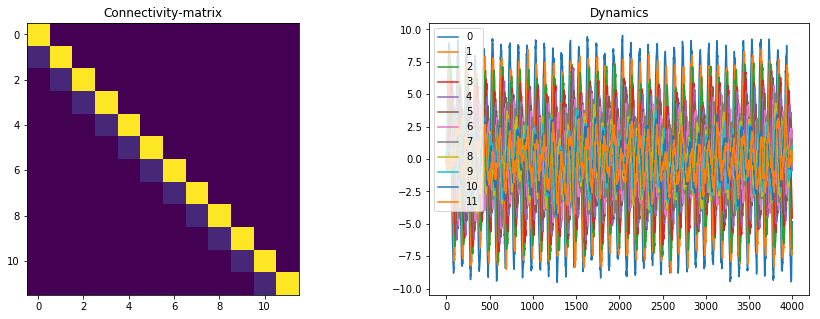

For max_lag = 1


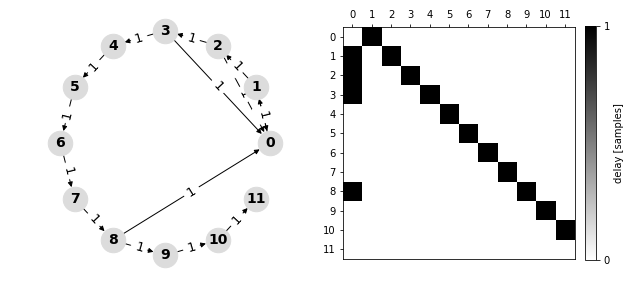

,src,trg,te,lag,p
4,0,1,0.658730,1,0.002
2,1,0,0.002699,1,0.002
5,1,2,0.556697,1,0.002
0,2,0,0.001462,1,0.002
6,2,3,0.472598,1,0.002
1,3,0,0.007953,1,0.002
7,3,4,0.381948,1,0.002
8,4,5,0.318378,1,0.002
9,5,6,0.262348,1,0.002
10,6,7,0.210707,1,0.002


For max_lag = 2


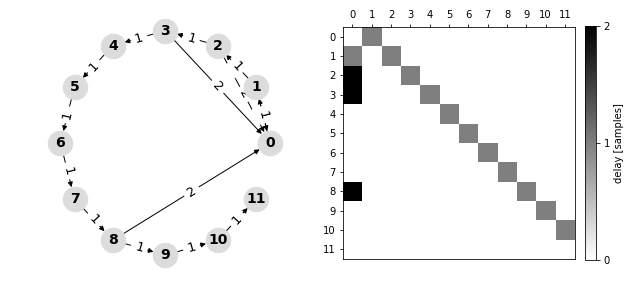

,src,trg,te,lag,p
4,0,1,0.316989,1,0.002
2,1,0,0.002546,1,0.002
5,1,2,0.285789,1,0.002
0,2,0,0.002062,2,0.002
6,2,3,0.283106,1,0.002
1,3,0,0.006622,2,0.002
7,3,4,0.240583,1,0.002
8,4,5,0.231851,1,0.002
9,5,6,0.194667,1,0.002
10,6,7,0.168417,1,0.002


For max_lag = 3


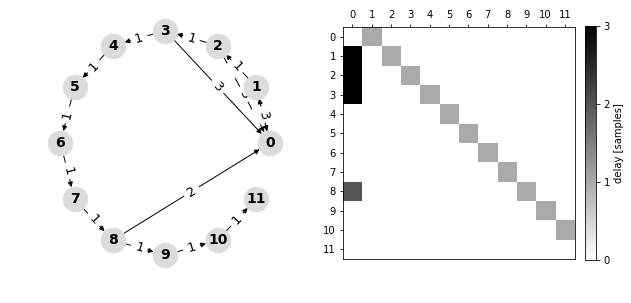

,src,trg,te,lag,p
4,0,1,0.215009,1,0.002
2,1,0,0.002346,3,0.002
5,1,2,0.202688,1,0.002
0,2,0,0.002588,3,0.002
6,2,3,0.211115,1,0.002
1,3,0,0.004498,3,0.002
7,3,4,0.192176,1,0.002
8,4,5,0.183462,1,0.002
9,5,6,0.164665,1,0.002
10,6,7,0.148319,1,0.002


For max_lag = 4


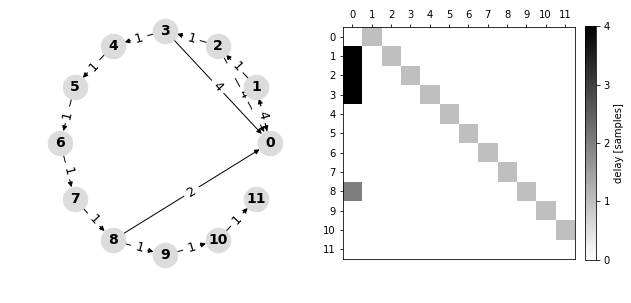

,src,trg,te,lag,p
4,0,1,0.169949,1,0.002
2,1,0,0.002535,4,0.002
5,1,2,0.161686,1,0.002
0,2,0,0.002274,4,0.002
6,2,3,0.168843,1,0.002
1,3,0,0.003777,4,0.002
7,3,4,0.159861,1,0.002
8,4,5,0.161139,1,0.002
9,5,6,0.145285,1,0.002
10,6,7,0.128186,1,0.002


For max_lag = 5


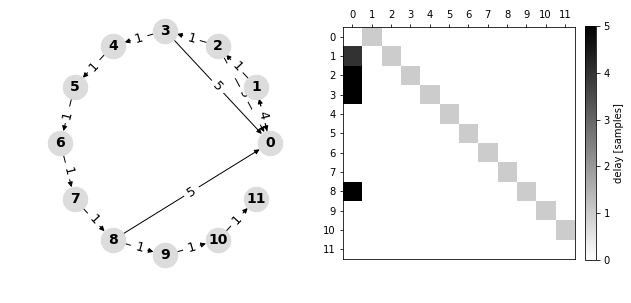

,src,trg,te,lag,p
4,0,1,0.142883,1,0.002
3,1,0,0.001585,4,0.002
5,1,2,0.140520,1,0.002
0,2,0,0.003423,5,0.002
6,2,3,0.145030,1,0.002
1,3,0,0.002670,5,0.002
7,3,4,0.142026,1,0.002
8,4,5,0.137590,1,0.002
9,5,6,0.126251,1,0.002
10,6,7,0.114833,1,0.002


For max_lag = 6


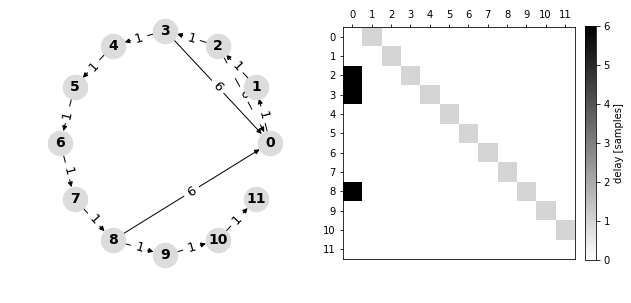

,src,trg,te,lag,p
3,0,1,0.122010,1,0.002
4,1,2,0.125347,1,0.002
0,2,0,0.007945,6,0.002
5,2,3,0.128459,1,0.002
1,3,0,0.002519,6,0.002
6,3,4,0.129687,1,0.002
7,4,5,0.124487,1,0.002
8,5,6,0.116938,1,0.002
9,6,7,0.107957,1,0.002
10,7,8,0.101984,1,0.002


In [5]:
# Plot dynamical system
DS1.plot()

for max_lag, results in zip(maxLagLst, resultsLst):
    print('For max_lag =', max_lag)
    # Plot inferred network to console and via matplotlib
    #results.print_edge_list(weights='max_te_lag', fdr=False)
    plot_network(results=results, weights='max_te_lag', fdr=False)
    plt.show()

    # Print details of TE estimation
    display(parseResults(results, param['N_NODE']))

### 2.2 Effect of number of datapoints

**Conclusions**:
* for 5-12 parameters, the rapid phase transition happens at approx 2000 points. So it is necessary to have at least 3000 datapoints for TE of false positives to be reliably significantly smaller than those of real connections

In [6]:
%%time
nDataLst = (10**(np.linspace(2, 5, 40))).astype(int)
resultsNDataLst = []

for N_DATA in nDataLst:
    paramThis = param.copy()
    paramThis['N_DATA'] = N_DATA
    
    DS1 = DynSys(paramThis)
    resultsNDataLst += [parseResults(DS1.computeTE(min_lag, max_lag), paramThis['N_NODE'])]

Adding data with properties: 12 processes, 100 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3)

testing candidate: (8, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 6), (3, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 2)]
final target samples: [(4, 1), (4, 6)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (10, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5

testing candidate: (4, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 6), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 6)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (9, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 3)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (6, 3)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 3)]
final target samples: [(7, 1)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6),

 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5,

testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 6), (4, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 2)]
final target samples: [(5, 1), (5, 6)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 6) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (11, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (9, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 2)]
final target samples: [(10, 1)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1,

testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 6)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 6), (2, 6)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 6)]
final target samples: [(3, 1), (3, 6)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (4, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (8, 5), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 5)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 5)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (9, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 6), (6, 2), (5, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 6), (6, 2)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1)

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 242 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 4) maxim

testing candidate: (5, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 3)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 6), (3, 3)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 3)]
final target samples: [(4, 1), (4, 6)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (0, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 4)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (9, 6), (8, 4)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 4)]
final target samples: [(9, 1), (9, 6)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3)

testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 6), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 6)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (8, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 4)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 6), (6, 4)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 4)]
final target samples: [(7, 1), (7, 6)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 6)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 6), (1, 6)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 6)]
final target samples: [(0, 1), (0, 6)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (2, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 6), (4, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 6)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 6) maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (11, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (10, 6), (10, 3), (9, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 2)]
final target samples: [(10, 1), (10, 6), (10, 3)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 6) maximum statistic, n_perm: 200
testing candidate: (11, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candi

testing candidate: (4, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 6), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 6)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (9, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (8, 6), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 6)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 6), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 6)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) includ

testing candidate: (5, 2) maximum statistic, n_perm: 200
testing candidate: (5, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 6), (5, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 2)]
final target samples: [(6, 1), (6, 6)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (11, 6), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1), (11, 6)]


Adding data with properties: 12 processes, 587 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candi

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 6), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 6)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (6, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (9, 6), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1), (9, 6)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 6) maximum statistic, n_perm: 200
testing candidate: (10, 4) maximum statistic, n_perm: 200
testing candidate: (10, 5) maximum statistic, n_per

testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (11, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 6), (2, 2), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 6), (2, 2)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
 -- not significant

-----------------------

testing candidate: (6, 3) maximum statistic, n_perm: 200
testing candidate: (6, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 3)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 6), (6, 3)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 3)]
final target samples: [(7, 1), (7, 6)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (8, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (2, 2) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 6), (2, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 2)]
final target samples: [(0, 1), (0, 6)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (10, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 6), (4, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 6)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 6) maximum statistic, n_perm: 200
testing candidate: (6, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) includ

testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (10, 6), (9, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 1)]
final target samples: [(10, 1), (10, 6)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 6) maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
 -- not significant

--------------------------

testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 6), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 6)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (9, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (8, 6), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 6)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 6), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 6)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 6), (5, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 6)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (6, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (11, 6), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1), (11, 6)]


Adding data with properties: 12 processes, 1425 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing cand

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 6), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 6)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (9, 3), (9, 6), (9, 5), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1), (9, 3), (9, 6), (9, 5)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 6) maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 6), (1, 1)]
omnibus test, n_perm: 500
 -- 

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 6), (6, 1)]
omnibus test, n_perm: 500
 -- 

testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 6), (1, 6)]
testing candidate: (1

testing candidate: (5, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (10, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10

testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (8, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (7, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (1, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
s

testing candidate: (6, 6) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

------------

testing candidate: (11, 6) maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]
testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (8, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

--------------

testing candidate: (11, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 6), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 6)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3

testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (8, 6), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 6)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

------------

testing candidate: (6, 6) maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

------------

testing candidate: (11, 6) maximum statistic, n_perm: 200
testing candidate: (11, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]
testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (9, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

--------------

testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (9, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

------------

testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (7, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

------------

testing candidate: (11, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 6), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 6)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3

testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 6), (5, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 6)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (11, 6), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1), (11, 6)]


Adding data with properties: 12 processes, 7017 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing cand

testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
s

testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate


testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 6), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 6)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (11, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 6), (5, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 6)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) includ

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (10, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (11, 6), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1), (11, 6)]


Adding data with properties: 12 processes, 10000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing ca

testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

------------

testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

------------

testing candidate: (7, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 6), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 6)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (10, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 6), (5, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 6)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) includ

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (4, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (11, 6), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1), (11, 6)]


Adding data with properties: 12 processes, 14251 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing can

testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (1, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
s

final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 6)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6),

testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 6), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 6)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- 

testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 6), (6, 2), (5, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 6), (6, 2)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 2) maximum statistic, n_perm: 200
 -- not significant

------------------------

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (11, 6), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1), (11, 6)]


Adding data with properties: 12 processes, 20309 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing ca

testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
s

testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (8, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
s

testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (2, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 6), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 6)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (7, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 6), (5, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 6)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
testing candidate: (7, 2) maximum statistic, n_perm: 200
 -- 

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (9, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (11, 6), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1), (11, 6)]


Adding data with properties: 12 processes, 28942 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing can

 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 6)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 

testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (8, 6), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 6)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
s

testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 6) maximum statistic, n_perm: 200
testing candidate: (6, 3) maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
 -- not significant



 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 1)]
final target samples: [(10, 1), (10, 6)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 6) maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), 

testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (8, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate


testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (11, 6) maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 6), (3, 6), (7, 6), (1, 6), (4, 6), (8, 6), (11, 6), (9, 6)]
testing candidate: (8, 6) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 6), (0, 5), (2, 6), (3, 6), (7, 6), (1, 6), (4, 6), (8, 6), (11, 6), (9, 6)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 6), (3, 6), (7, 6), (1, 6), (4, 6), (8, 6), (11, 6), (9, 6)]
final target samples: [(0, 1)

testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

------------

testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 6) maximum statistic, n_perm: 200
testing candidate: (10, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (0, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
sele

testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 6), (2, 2), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 6), (2, 2)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

------------------------

testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (6, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 6), (6, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 1)]
final target samples: [(7, 1), (7, 6)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (0, 4) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (4,

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 6), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 6)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 4) maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
 -- 

testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (7, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (9, 6), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1), (9, 6)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 6) maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (

final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 6)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6),

testing candidate: (5, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 6), (6, 3), (5, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 6), (6, 3)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1)

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (10, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (11, 6), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1), (11, 6)]


Adding data with properties: 12 processes, 100000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing c

omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 6)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7

testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (6, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (8, 6), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 6)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: All-NaN slice encountered
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=100.0, right=100.0
  self.set_xlim(upper, lower, auto=None)


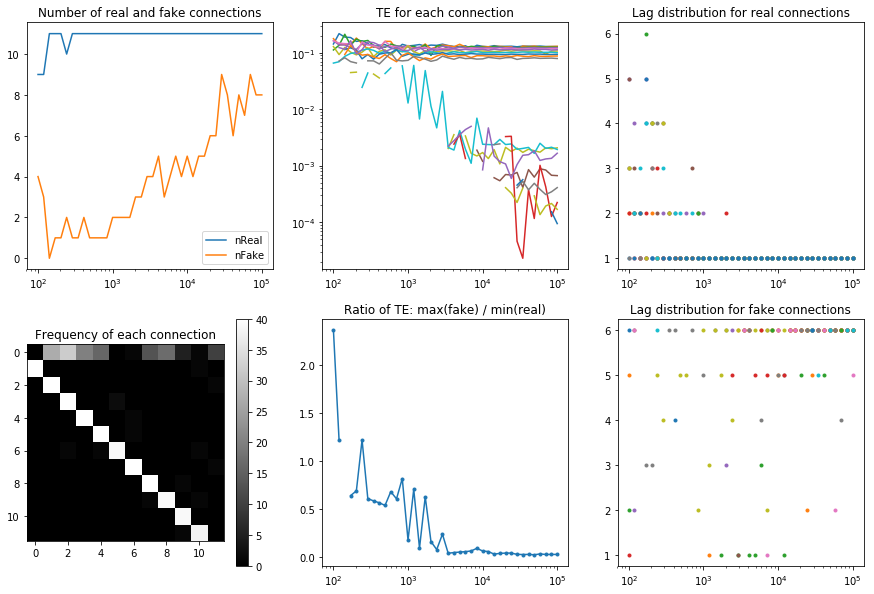

In [8]:
analysePlotResults(nDataLst, resultsNDataLst, DS1)

### 2.3 Effect of oscillation period

Does the frequency of input affect TE or false positive rate?

In [10]:
%%time
TLst = (2**(np.linspace(2, 8, 7))).astype(int)
resultsTLst = []

for T in TLst:
    paramThis = param.copy()
    paramThis['T'] = T
    
    DS1 = DynSys(paramThis)
    resultsTLst += [parseResults(DS1.computeTE(min_lag, max_lag), paramThis['N_NODE'])]

Adding data with properties: 12 processes, 4000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 4) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2)

 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), 

testing candidate: (10, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10

testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (9, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)

testing candidate: (1, 2) maximum statistic, n_perm: 200
testing candidate: (1, 3) maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (11, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
s

testing candidate: (6, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (10, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (3, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 4000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 5) maxi

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 4), (3, 1)]
omnibus test, n_perm: 500
 -- s

testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

------------

testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (5, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

------------

testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (

testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

------------

testing candidate: (10, 6) maximum statistic, n_perm: 200
testing candidate: (10, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (0, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

----------------

testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

------------

testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (9, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

------------

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: All-NaN slice encountered


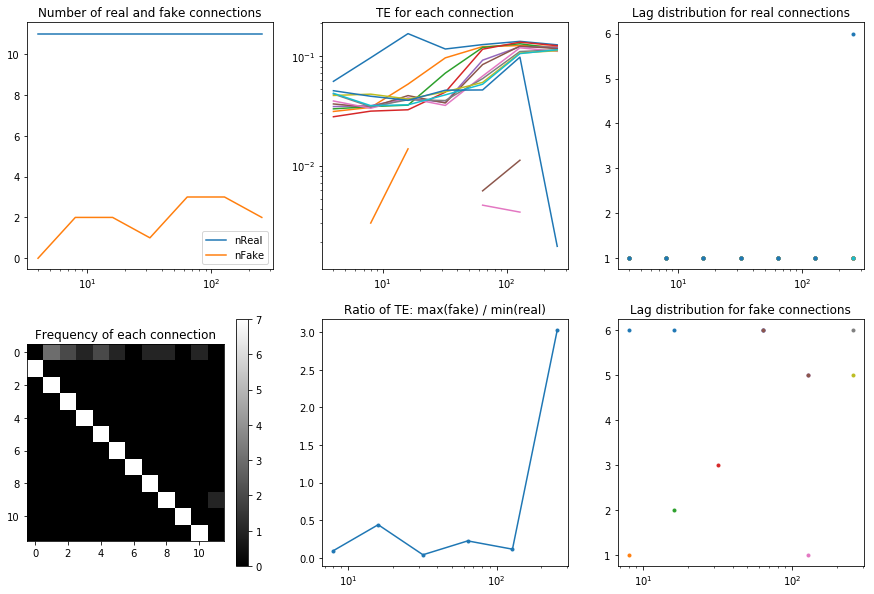

In [11]:
analysePlotResults(TLst, resultsTLst, DS1)

### 2.4 Effect of intrinsic noise

Intrinsic noise is occuring inside of the dynamic variables, so it propagates the same way as the signal. To some extent, this variable is the effect of high frequency signal.

* **Perhaps drop this test as useless**?

In [12]:
%%time
STDLst = 0.01 * (10**(np.linspace(0, 2.3, 8))).astype(int)
resultsSTDLst = []

for STD in STDLst:
    paramThis = param.copy()
    paramThis['STD'] = STD
    
    DS1 = DynSys(paramThis)
    resultsSTDLst += [parseResults(DS1.computeTE(min_lag, max_lag), paramThis['N_NODE'])]

Adding data with properties: 12 processes, 4000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6,

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (0, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 6), (4, 3), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 6), (4, 3)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 4) maximum statistic, n_perm: 200
testing candidate: (5, 3) maximum statistic, 

testing candidate: (9, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (7, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1), (3, 1)]
testing candidate: (3

testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
se

testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
se

testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (10, 5) maximum statistic, n_perm: 200
 -- not significant


testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

------------

testing candidate: (10, 6) maximum statistic, n_perm: 200
testing candidate: (10, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (9, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

----------------

 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 6), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 6)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4),

testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (10, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 6), (6, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 1)]
final target samples: [(7, 1), (7, 6)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (8, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) includ

testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (7, 5) maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
testing candidate: (4, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 6), (7, 5), (1, 6), (3, 4)]
testing candidate: (2, 6) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 6), (2, 6), (7, 5), (1, 6), (3, 4)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 6), (7, 5), (1, 6), (3, 4)]
final target samples: [(0, 1), (0, 6)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidat

testing candidate: (5, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (10, 6) maximum statistic, n_perm: 200
testing candidate: (10, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (9, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

----------------

testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 6), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 6)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 6), (6, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 1)]
final target samples: [(7, 1), (7, 6)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (8, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (1, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 6), (8, 6), (2, 5)]
testing candidate: (2, 5) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 6), (3, 6), (8, 6), (2, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 6), (8, 6), (2, 5)]
final target samples: [(0, 1), (0, 6)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
testing candid

testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 5), (4, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 5)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 6) maximum statistic, n_perm: 200
testing candidate: (6, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (6, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (9, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 1)]
final target samples: [(10, 1)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0,

testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (8, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)

testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1), (9, 1)]
testing candidate: (9, 1) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (7, 1), (9, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1), (9, 1)]
final target samples: [(8, 1)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 2) maximum statistic, n_perm: 

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: All-NaN slice encountered


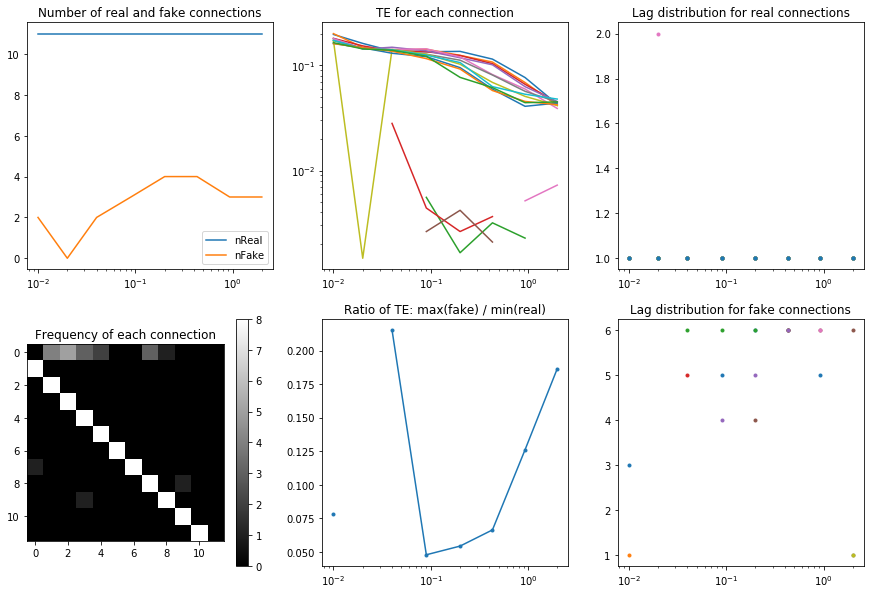

In [13]:
analysePlotResults(STDLst, resultsSTDLst, DS1)

## 2.5 Effect of coupling

Test at what coupling strength does IDTxl break down. 
* NOTE: Coupling strength, observable noise and data quantity are likely all related to estimation quality

In [16]:
%%time
ALPHALst = 1 - 0.1**(np.linspace(0.5, 2, 8))
resultsALPHALst = []

for ALPHA in ALPHALst:
    paramThis = param.copy()
    paramThis['ALPHA'] = ALPHA
    
    DS1 = DynSys(paramThis)
    resultsALPHALst += [parseResults(DS1.computeTE(min_lag, max_lag), paramThis['N_NODE'])]

Adding data with properties: 12 processes, 4000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6,

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 6), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 6)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (3, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (9, 6), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1), (9, 6)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 6) maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (

testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (0, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

------------

testing candidate: (7, 6) maximum statistic, n_perm: 200
testing candidate: (7, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (8, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

------------

testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (4

testing candidate: (5, 6) maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (3, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

------------

testing candidate: (10, 6) maximum statistic, n_perm: 200
testing candidate: (10, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

----------------

testing candidate: (3, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 6), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 6)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 6) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (8, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 6), (6, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 1)]
final target samples: [(7, 1), (7, 6)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 6) maximum statistic, n_perm: 200
testing candidate: (8, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
testing candidate: (4, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 6), (3, 1), (8, 5)]
testing candidate: (8, 5) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 6), (1, 6), (3, 1), (8, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 6), (3, 1), (8, 5)]
final target samples: [(0, 1), (0, 6)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
testing candid

testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (10, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 6), (4, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 6)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3

testing candidate: (5, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (9, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 1)]
final target samples: [(10, 1)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 

testing candidate: (2, 3) maximum statistic, n_perm: 200
testing candidate: (9, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 3)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 6), (2, 3)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 3)]
final target samples: [(3, 1), (3, 6)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3)

testing candidate: (5, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6),

testing candidate: (0, 2) maximum statistic, n_perm: 200
testing candidate: (6, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 6), (0, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 2)]
final target samples: [(1, 1), (1, 6)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include

testing candidate: (5, 4) maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 4)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (5, 4)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 4)]
final target samples: [(6, 1)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)

testing candidate: (6, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 4000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

----------

testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (3, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 5)]
final target samples: [(4, 1)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)

testing candidate: (8, 2) maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (8, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 2)]
final target samples: [(9, 1)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: All-NaN slice encountered


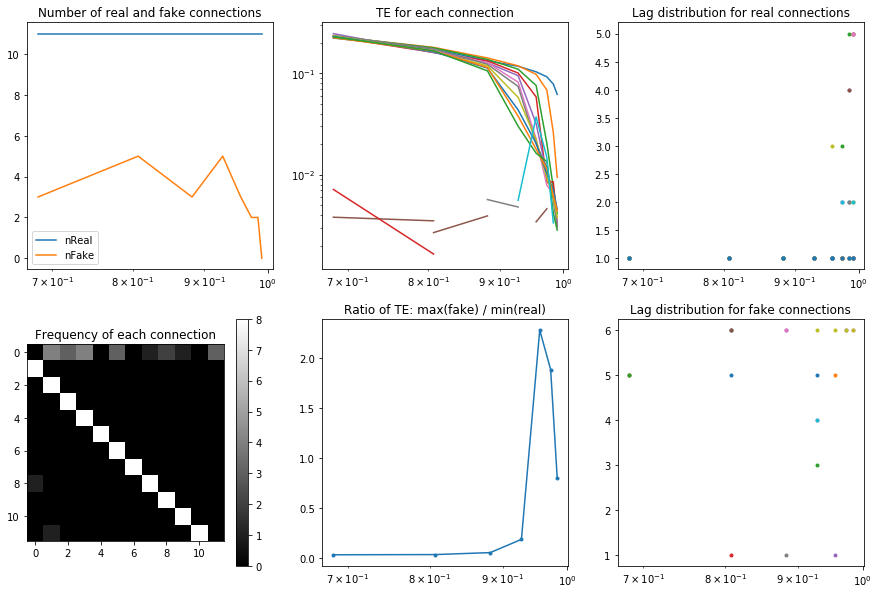

In [17]:
analysePlotResults(ALPHALst, resultsALPHALst, DS1)

## 2.6 Effect of Observable Noise

**IMPLEMENT ME**

## 2.7 Effect of 1-bar multi-trial

Yaro estimates Dynamic TE. He estimates TE from `(N_TRIAL, MAX_TE_LAG, N_CHANNEL)` by sweeping a window of size `MAX_TE_LAG` over his dataset. Given normal values of other parameters, how does false positive rate scale with `N_TRIAL`?

In [18]:
%%time
paramThis = param.copy()
paramThis['T'] = 10
paramThis['N_DATA'] = 1000000

DS1 = DynSys(paramThis)

nTrialLst = (10**(np.linspace(2, 4, 10))).astype(int)

resultsNTrialLst = []
for N_TRIAL in nTrialLst:
    # Imitate trials by randomly sampling blocks length MAX_LAG from history of one long trial
    startRes = np.random.randint(0, paramThis['N_DATA'] - max_lag - 1, N_TRIAL)
    dataResample = np.zeros((N_TRIAL, max_lag+1, param['N_NODE']))
    for i in range(N_TRIAL):
        dataResample[i] = DS1.data[:, startRes[i] : startRes[i] + max_lag + 1].transpose()

    # IDTXL
    dataIDTxl = Data(dataResample, dim_order='rsp')

    network_analysis = MultivariateTE()
    settings = {'cmi_estimator': 'JidtGaussianCMI',
                'max_lag_sources': max_lag,
                'min_lag_sources': min_lag}

    rez = network_analysis.analyse_network(settings=settings, data=dataIDTxl)
    resultsNTrialLst += [parseResults(rez, paramThis['N_NODE'])]

Adding data with properties: 12 processes, 7 samples, 100 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1

testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 6)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (2, 6)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 6)]
final target samples: [(5, 1)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (6, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), 

 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 7 samples, 166 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidat

 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(5, 1)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (6, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3

testing candidate: (4, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (10, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 2)]
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 7 samples, 278 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum

testing candidate: (5, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (1, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (2, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (9, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 1)]
final target samples: [(10, 1)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (11, 1) maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5

 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1)

testing candidate: (8, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]
testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (10, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5),

testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), 

testing candidate: (8, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (1, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (2, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 3), (1, 6), (1, 4), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 3), (1, 6), (1, 4)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candida

testing candidate: (7, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (6, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(0, 1), (0, 2), (0, 6), (0, 4), (0, 3), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (1, 3) maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
testing candidate: (1, 4) maximum statistic, n_perm: 200
testing candidate: (1, 2) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

-----------

testing candidate: (6, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (1, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables:

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (1, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 7 samples, 3593 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
testing candidate: (0, 6) maxim

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (11, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]
testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (5, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)

testing candidate: (10, 6) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10

KeyboardInterrupt: 

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: All-NaN slice encountered


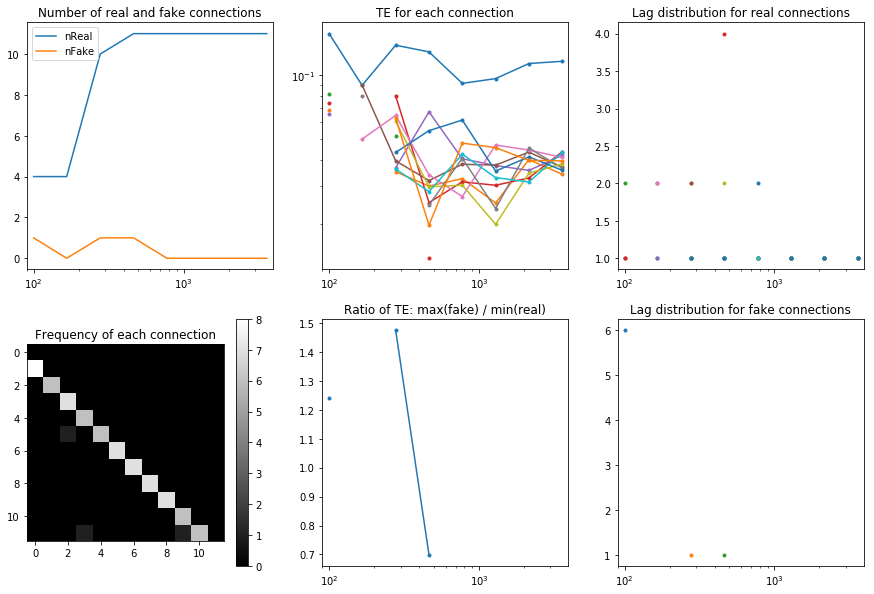

In [28]:
analysePlotResults(nTrialLst[:len(resultsNTrialLst)], resultsNTrialLst, DS1)